In [325]:
import os
import sys
import nltk
import math
import shlex
import itertools
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from string import punctuation

from pandas import Series
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
from matplotlib.gridspec import GridSpec

In [326]:
data_folder_channels='/media/aruiz/data/channels_clean_data/'
fileName2=os.path.join(data_folder_channels,'all_channels_cat_clean.csv')
# fileName2=os.path.join(data_folder_channels,'gta_data_clean.csv')
df=pd.read_csv(fileName2)
df=df.sort_values(by=['views'],ascending=True)
df=df.fillna("N/A")
df=df.reset_index(drop=True)
lemmatizer = WordNetLemmatizer()
stopWords = set(stopwords.words('english'))
searchKeys=["minecraft","roblox","call", "of", "duty","overwatch", "grand","theft","auto","league","legend",
            "Happy","wheel","five", "night", "at", "freddy's","agar.io", "pokemon"]
# searchKeys=["grand","theft","auto"]
top_words= ["game", "gaming", "video", "gameplay", "funny", "play", "let","cod", "mod", "tutorial"]
# quartile3=246352
quartile3=42267
#punctuation list to exclude from keywords
exclude = set(punctuation)

/home/aruiz/.virtualenvs/LetsPlayData/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Frequent words (unigrams/bigrams)

In [329]:

all_keys_u=[] # all tag/words for each channel
all_keys_b=[] # all co-ocurrence of tags (bigrams)
all_categories=[] # top words with the most present categories

for n in range(0,len(df)):
    if (df.keywords[n]!="N/A") and (df.views[n]>quartile3):
        channel_keys=[]
        
        try:
            l = shlex.split(df.keywords[n])

        except:
            l = df.keywords[n].split()
            
        for kw in l:
            kw_id = kw.lower().replace("'", "").replace("´", "").replace("’", "").replace("`", "")
            single_keys=nltk.word_tokenize(kw_id)
            for key in single_keys:
                key=lemmatizer.lemmatize(key)
                if (key not in stopWords)and(len(key)>1):
                    if (key not in channel_keys) and (key not in searchKeys):
                        channel_keys.append(key)
                        
        #clean all digits and punctuation from keywords
        channel_keys_clean=remove_dig_punct(channel_keys)
        
        #find category of the keyword /game belongs to
        for key in channel_keys_clean:
            all_keys_u.append(key)
            if key in top_words:
                single_cat=nltk.word_tokenize(str(df.game_q.iloc[n]))
                for cat in single_cat:
                    string=key+" "+ str(cat)
                    all_categories.append(string)
                    
        edges= itertools.combinations(channel_keys_clean,2)
        for edge in edges:
            t=(edge[0],edge[1])
            all_keys_b.append(t)
            
        df.loc[n,"num_tags"]=len(channel_keys_clean)

In [328]:
def remove_dig_punct(list1):
    new=[]
    for n in range (0, len(list1)):
        #removing digits
        res=''.join([i for i in list1[n] if not i.isdigit()])
        #removing punctuation
        s = ''.join(ch for ch in res if ch not in exclude)
        if (s !="") and (s not in new):
            if (len(s)>1):
                new.append(s)
    return (new)

In [330]:
counts_u=Series(all_keys_u)
cu=counts_u.value_counts()
counts_b=Series(all_keys_b)
cb=counts_b.value_counts()
counts_c=Series(all_categories)
ca=counts_c.value_counts()

# Tag co-ocurrence network

In [331]:
# adding nodes
g = nx.Graph()
for n in range (0,len(cu)):
    g.add_node(cu.index[n], type='keyword', weight=int(cu[n]))

In [332]:
# adding edges
for n in range (0,len(cb)):
    edge=cb.index[n]
    if g.has_edge(edge[0],edge[1]):
        g[edge[0]][edge[1]]['weight'] += cb[n]
    else:
#         w=(cb[n])/math.sqrt(cu.loc[edge[0]]+cu.loc[edge[1]])
        g.add_edge(edge[0],edge[1], weight=cb[n]) 

In [333]:
for u,v,d in g.edges(data=True):
    d['weight']=d['weight']/(math.sqrt(cu.loc[u]*cu.loc[v]))

In [363]:
H=g.copy()
for n in range (14047, len(cu)):
    H.remove_node(cu.index[n])

## ego graph

In [364]:
tag='funny'
let_ego=nx.ego_graph(H,tag,radius=1)

In [387]:
len(G.nodes())

124

In [372]:
cum=0
highest=0

for u,v,d in G.edges(data=True):
    cum+=d['weight']
    if highest<d['weight']:
        highest=d['weight']
        val=u
        val2=v
print(cum/502944)
print (str(highest)+""+val+" "+val2 )

0.0002072104726414487
0.4971097175996318moment funny


In [383]:
#mean of the weight of the edges
H=let_ego.copy()

for u,v,d in let_ego.edges(data=True):
    if (d['weight']<0.06):
        H.remove_edge(u,v)
#mean=0.15

In [386]:
G=H.copy()
a=list(nx.isolates(H))
G.remove_nodes_from(a)

In [385]:
H=G.copy()
for u,v,d in G.edges(data=True):
    if (u!=tag) and (v!=tag):
        H.remove_edge(u,v)

## save to gexf file

In [388]:
nx.write_gexf(G,"semantic_fun3.gexf")

In [11]:
nx.draw_spring(let_ego,with_labels=True)

In [13]:
plt.savefig("ego1.png")

# Save keywords txt

In [22]:
i=0
f= open ('bigrams.txt','w')
for n in range (0,len(cb)):
    f.write(str(cb.index[n][0])+" " +str(cb.index[n][1]))
    f.write('\n')
    i+=1
i

1569755

# Tags distribution

In [74]:
# # English language filter
# i=0
# d=enchant.Dict('en_US')
# counts2=list(counts)
# counts_eng=[]
# for word in counts2:
#     if (d.check(word)):
#         del counts[word]
#         counts_eng.append(counts[word])

In [2]:
df=df.sort_values(by=['views'],ascending=True)
# plt.xticks(np.arange(42261, max(df['views'])+100, 1000000))
# df.iloc[0:103716].plot(x='views', y='num_tags', style='.', figsize=(18,10), xticks=np.arange(0, 42661, 10000), rot=90)
# df.iloc[103716:138288].plot(x='views', y='num_tags', style='.', figsize=(18,10), xticks=np.arange(42661, 500000, 10000), rot=90)
# df.iloc[120371:130000].plot(x='views', y='num_tags', style='.', figsize=(18,10), rot=90)
# df.iloc[128871:138288].plot(x='views', y='num_tags', style='.', figsize=(18,10), rot=90)
#xticks

NameError: name 'df' is not defined

In [66]:
quartile3=42261 
all_keys_u=[] # all tag/words for each channel
all_keys_b=[] # all co-ocurrence of tags (bigrams)

for n in range(0,len(df)):
    if (df.description[n]!="N/A") and (df.views[n]>quartile3):
        channel_keys=[]
        
        try:
            l = shlex.split(df.description[n])

        except:
            l = df.description[n].split()
            
        for kw in l:
            kw_id = kw.lower().replace("'", "").replace("´", "").replace("’", "").replace("`", "")
            single_keys=nltk.word_tokenize(kw_id)
            for key in single_keys:
                key=lemmatizer.lemmatize(key)
                if (key not in stopWords)and(len(key)>1):
                    if (key not in channel_keys) and (key not in searchKeys):
                        channel_keys.append(key)
        
        for key in channel_keys:
            all_keys_u.append(key)
        
#         edges= itertools.combinations(channel_keys,2)
#         for edge in edges:
#             t=(edge[0],edge[1])
#             all_keys_b.append(t)
            
        df.loc[n,"num_unigrams"]=len(channel_keys)

In [1]:
# df.plot(x='views', y='num_unigrams', style='.', figsize=(12,10))

In [78]:
len(np.arange(42261, max(df['views']), 250000000))

76

In [109]:
df2=df['views']>42266

## Tag and no tag distribution among channels

In [21]:
# df=df.sort_values(by=['views'],ascending=True)
df=df.sort_values(by=['views'],ascending=False)

In [7]:
q1=df['num_tags'].iloc[0:34572].isna().value_counts()
q2=df['num_tags'].iloc[34572:69144].isna().value_counts()
q3=df['num_tags'].iloc[69144:103716].isna().value_counts()
q4=df['num_tags'].iloc[103716:138288].isna().value_counts()
q5=df['num_tags'].iloc[124460:138288].isna().value_counts()

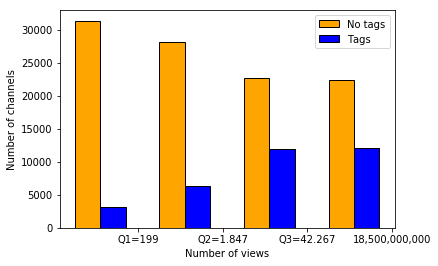

In [8]:
barWidth = 0.3
# height of the blue bars
bars1 = [31392, 28230,22681,22416]
# height of the cyan bars
bars2 = [3180,6342,11891,12156]
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
#plot bars
plt.bar(r1, bars1, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='No tags')
plt.bar(r2, bars2, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Tags')
plt.xticks([r + (barWidth*2) for r in range(len(bars1))], ['Q1=199', 'Q2=1.847', 'Q3=42.267', '18,500,000,000'])
plt.xlabel('Number of views')
plt.ylabel('Number of channels')
plt.legend()

## Distribution of top ten words among the top ten channels

In [298]:
df_hm=pd.read_csv("heatmap.csv")

In [299]:
df=df_hm.set_index('TAG')

In [312]:
df_hm=df_hm.reset_index(drop=True)
df_hm=df_hm.drop(['TAG'], axis=1)
array=df_hm.values

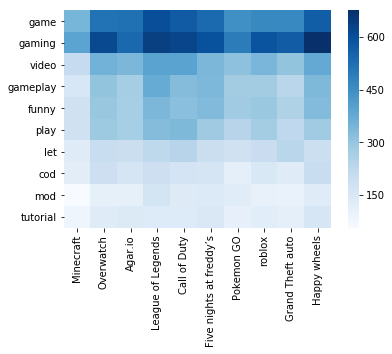

In [324]:
ylabels=['game','gaming', 'video', 'gameplay', 'funny', 'play','let','cod', 'mod', 'tutorial']
sns.heatmap(df_hm,yticklabels=ylabels, cmap='Blues')

In [316]:
df_hm

,Minecraft,Overwatch,Agar.io,League of Legends,Call of Duty,Five nights at freddy’s,Pokemon GO,roblox,Grand Theft auto,Happy wheels
0,349.0,518.0,521.0,603.0,573.0,538.0,448.0,463.0,466.0,564.0
1,396.0,617.0,541.0,638.0,626.0,597.0,494.0,592.0,569.0,675.0
2,213.0,356.0,340.0,399.0,399.0,341.0,313.0,342.0,307.0,379.0
3,154.0,306.0,276.0,374.0,325.0,339.0,281.0,280.0,235.0,335.0
4,179.0,297.0,274.0,341.0,320.0,333.0,282.0,294.0,253.0,331.0
5,181.0,290.0,272.0,325.0,336.0,287.0,242.0,277.0,225.0,282.0
6,131.0,203.0,198.0,226.0,241.0,198.0,181.0,201.0,235.0,194.0
7,123.0,191.0,164.0,190.0,166.0,161.0,117.0,150.0,130.0,202.0
8,57.0,111.0,112.0,170.0,136.0,142.0,129.0,103.0,102.0,134.0
9,88.0,134.0,141.0,137.0,137.0,148.0,110.0,125.0,116.0,159.0


In [128]:
cu

game             3171
gaming           3043
video            2271
gta              2095
gameplay         2053
funny            1911
play             1720
let              1310
cod              1272
black            1251
ops              1159
xbox             1013
mod               964
tutorial          961
ps                930
lol               925
music             894
warfare           842
pc                819
montage           774
commentary        771
mw                771
online            711
modern            709
comedy            697
review            645
gamer             644
best              619
world             597
moment            577
                 ... 
defaultsound        1
jal                 1
festnetz            1
kontra              1
mrcodinatorxx       1
deathadder          1
maestus             1
floyd               1
comedias            1
комбо               1
daretage            1
expel               1
bahadır             1
résaux              1
kina      

In [133]:
#get the frequency distribution of tags
n_tags=Series(cu.values).value_counts()
# n_tags
#the tags with frequency 1 are 41744

In [130]:
mean=cu.sum()/len(cu)
# print(mean)
#mean is 4.028

In [12]:
cu_new2=cu.iloc[0:14047]
# cu_new3=cu_new2.iloc[1003:1256]
# cu_new2[501:505]

In [105]:
#get the number of characters to recognize
tot_len=0
for n in range(0, len(cu_new2)):
    tot_len=tot_len+len(cu_new2.index[0])
print (tot_len)

56300


### Fitting curve to power law

In [14]:
cu_new2

game              3171
gaming            3043
video             2271
gta               2095
gameplay          2053
funny             1911
play              1720
let               1310
cod               1272
black             1251
ops               1159
xbox              1013
mod                964
tutorial           961
ps                 930
lol                925
music              894
warfare            842
pc                 819
montage            774
mw                 771
commentary         771
online             711
modern             709
comedy             697
review             645
gamer              644
best               619
world              597
moment             577
                  ... 
failz                2
terrible             2
katakana             2
tsum                 2
watcher              2
mane                 2
archive              2
shrimp               2
vadr                 2
humoristique         2
zonday               2
blackman             2
veil       

In [17]:
cb

(let, play)                  1239
(black, ops)                 1132
(video, game)                 928
(modern, warfare)             605
(gaming, game)                509
(funny, moment)               480
(game, gaming)                466
(gta, online)                 448
(game, play)                  418
(gaming, video)               400
(game, gameplay)              368
(gaming, funny)               367
(gaming, play)                353
(gaming, gameplay)            345
(gta, mod)                    343
(game, video)                 319
(game, funny)                 301
(play, game)                  299
(gaming, let)                 298
(gameplay, game)              293
(game, let)                   293
(cod, ops)                    286
(san, andreas)                284
(cod, black)                  283
(funny, video)                283
(ps, xbox)                    273
(cod, mw)                     267
(xbox, one)                   266
(game, xbox)                  260
(gameplay, com

In [21]:
cb.index[0][0]

'let'

## clean all inverted tuples

In [75]:
unique_weights=[]
for n in range (0,1569755):
    try:
        edge=cb.index[n]
        edge2=(edge[1],edge[0])
        if edge2 in cb.index:
            new_value= cb[edge]+cb[edge2]
            cb=cb.drop(edge2)
            unique_weights.append(new_value)
        else:
            unique_weights.append(cb[edge])
#         unique_relations.append(edge)
    except:
        break

In [45]:
x=('game', 'gaming')
y=('a','b')

In [46]:
if y in cb.index:
    print ('t')

In [55]:
cb2=cb.drop(x)
print(cb2.index[7])


('game', 'play')


In [76]:
cb

(let, play)                  1239
(black, ops)                 1132
(video, game)                 928
(modern, warfare)             605
(gaming, game)                509
(funny, moment)               480
(gta, online)                 448
(game, play)                  418
(gaming, video)               400
(game, gameplay)              368
(gaming, funny)               367
(gaming, play)                353
(gaming, gameplay)            345
(gta, mod)                    343
(game, funny)                 301
(gaming, let)                 298
(game, let)                   293
(cod, ops)                    286
(san, andreas)                284
(cod, black)                  283
(funny, video)                283
(ps, xbox)                    273
(cod, mw)                     267
(xbox, one)                   266
(game, xbox)                  260
(gameplay, commentary)        259
(game, pc)                    255
(gameplay, play)              249
(cod, warfare)                249
(black, warfar

In [71]:
cb.at['value',('gaming','game')]= 5

ValueError: Not enough indexers for scalar access (setting)!

In [78]:
unique_weights

[1272,
 1137,
 1247,
 652,
 975,
 522,
 472,
 717,
 638,
 661,
 560,
 552,
 541,
 422,
 542,
 462,
 549,
 532,
 284,
 531,
 499,
 526,
 445,
 281,
 391,
 372,
 371,
 483,
 425,
 457,
 460,
 259,
 260,
 379,
 337,
 229,
 354,
 387,
 287,
 333,
 293,
 328,
 346,
 337,
 401,
 372,
 359,
 367,
 381,
 305,
 303,
 382,
 297,
 279,
 348,
 280,
 376,
 205,
 376,
 284,
 255,
 252,
 280,
 330,
 258,
 340,
 342,
 306,
 286,
 266,
 200,
 266,
 178,
 257,
 274,
 209,
 262,
 209,
 249,
 227,
 246,
 250,
 233,
 216,
 203,
 218,
 254,
 219,
 230,
 211,
 218,
 247,
 144,
 224,
 144,
 235,
 240,
 139,
 225,
 214,
 174,
 212,
 222,
 245,
 175,
 231,
 255,
 231,
 187,
 212,
 202,
 195,
 245,
 186,
 155,
 133,
 247,
 142,
 210,
 171,
 122,
 188,
 188,
 211,
 180,
 206,
 193,
 170,
 212,
 170,
 209,
 122,
 185,
 147,
 208,
 161,
 180,
 193,
 182,
 177,
 198,
 164,
 157,
 162,
 170,
 206,
 181,
 131,
 190,
 169,
 146,
 167,
 171,
 179,
 168,
 167,
 139,
 180,
 110,
 178,
 179,
 188,
 146,
 187,
 164,
 106,
 

In [62]:
new_cb.index[0]=('a','b')

AttributeError: 'property' object has no attribute 'index'